#  Zero-Noise Extrapolation (ZNE)

- **Author**: Théo HUET
- **Date**: 16/02/2026 - 17/02/2026

Implement **Zero-Noise Extrapolation** (ZNE) from the Temme-Bravyi-Gambetta paper using **Qiskit** to numerically verify :

$$ E(\lambda) = E^* +a_1\lambda + a_2\lambda^2+\dots$$

and if the Richardson extrapolation improves the estimate.

In [18]:
!pip install -q qiskit qiskit-aer qiskit-ibm-runtime pylatexenc


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## Initializing the Circuit

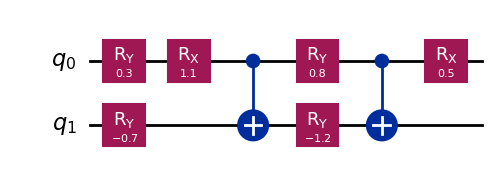

In [19]:
import qiskit

from qiskit import QuantumCircuit
import numpy as np

def initialize_circuit() -> QuantumCircuit:
  theta = [0.3, 1.1, -0.7, 0.8, -1.2, 0.5] # 6 angles, certain assez grand pour avoir de l'intrication et éviter d'avoir un cas trivial

  # création du circuit
  qc = QuantumCircuit(2)

  # application des portes
  qc.ry(theta[0], 0)
  qc.ry(theta[2], 1)

  qc.rx(theta[1], 0)

  qc.cx(0,1)

  qc.ry(theta[3], 0)
  qc.ry(theta[4], 1)

  qc.cx(0,1)

  qc.rx(theta[5], 0)
  return qc

qc = initialize_circuit()

# affiche notre circuit terminé
qc.draw(output="mpl", style="iqp")

### Why is this circuit good for ZNE?

- The two CNOTs make the circuit very sensitive to depolarizing noise,
- It is not trivially symmetric, so the observable will not be 0 by accident,
- Long enough to see an error,
- Short enough to remain in the perturbative regime.

---

## Observable

We will measure $\langle Z_0 Z_1\rangle$, the **correlation**,
because this quantity is sensitive to entanglement, easy to reconstruct from the counts, and physically interesting.

Indeed, we have:
$$ \langle Z_0 Z_1\rangle = P(00) + P(11) - P(01) - P(10)$$

### Simulation of the state coming out of the circuit

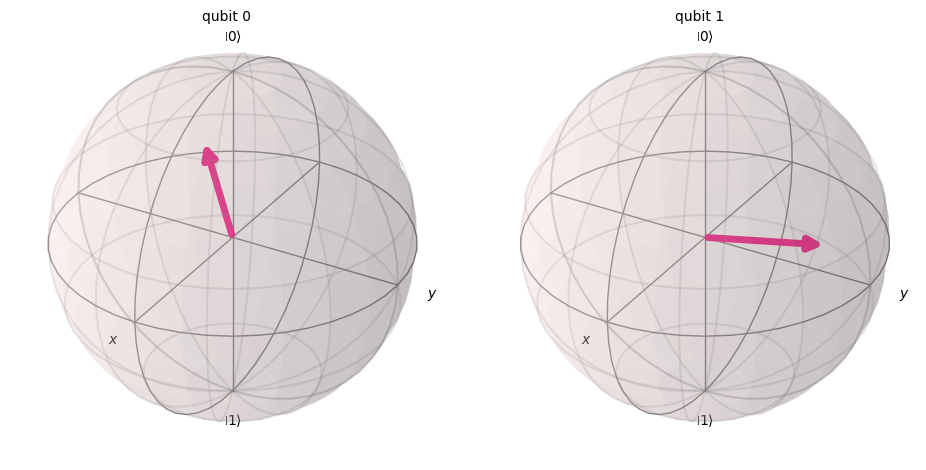

In [20]:
from qiskit_aer import AerSimulator
from qiskit import transpile

from qiskit.visualization import plot_bloch_multivector

shots = 10000

def simulate(qc:QuantumCircuit, shots:int=10000) -> list:
  '''Simule un circuit et retourne le vecteur d'état.'''
  qc = qc.copy()
  qc.save_statevector()
  simulator = AerSimulator(method="statevector")

  qc_t = transpile(qc, simulator)
  job = simulator.run(qc_t, shots=shots)
  result = job.result()
  state = result.get_statevector()
  return state

psi = simulate(qc, shots)
plot_bloch_multivector(psi)

### calculation of the “ideal” correlation

$$\langle Z_0 Z_1\rangle = |C_{00}|^2 + |C_{1}|^2 - |C_{01}|^2 - |C_{10}|^2$$

In [21]:
def P(c_ij:float) -> float:
  return c_ij.conj() * c_ij

def compute_correlation(statevector:list) -> float:
  return (P(statevector[0]) + P(statevector[3]) - P(statevector[1]) - P(statevector[2])).real

def ideal_correlation(qc:QuantumCircuit, shots:int=10000) -> float:
  psi = simulate(qc, shots) # avec le circuit simple sans bruit...
  return compute_correlation(psi)

correlation = ideal_correlation(qc, shots)
print("correlation :", correlation)

correlation : -0.6390459210354608


---

## Apply noise

In [22]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def initialize_noise_model(p:float = 0.01) -> NoiseModel:
  noise_model = NoiseModel()

  error_1q = depolarizing_error(p, 1) # Bruit 1-qubit
  error_2q = depolarizing_error(p, 2) # Bruit 2-qubit

  # bruit 1q sur ['rx','ry'], bruit 2q sur ['cx']
  noise_model.add_all_qubit_quantum_error(error_1q, ['rx','ry'])
  noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
  return noise_model

def simulate_noise(qc:QuantumCircuit, p:float, shots:int=10000) -> list:
  '''Simule un circuit avec un bruit et retourne la matrice densité.'''
  qc = qc.copy()
  qc.save_density_matrix()
  noise_model = initialize_noise_model(p)

  simulator = AerSimulator(method="density_matrix", noise_model=noise_model) # on a besoin de density matrix car avec le bruit notre etat ne seras plus pure donc plus un state vector

  qc_t = transpile(qc, simulator, optimization_level=0)
  job = simulator.run(qc_t, shots=shots)
  result = job.result()
  density_matrix = result.data(0)['density_matrix']

  return density_matrix

p = 0.01
qc_noisy = initialize_circuit()
rho = simulate_noise(qc_noisy, p, shots)

### Correlation with the density matrix

$$\langle Z_0 Z_1\rangle = Tr[(Z\otimes Z)\rho]$$

In [23]:
def difference(x,y):
  return np.abs(x-y)

def compute_correlation_density_matrix(rho:list) -> float:
  Z = np.array([[1, 0], [0, -1]], dtype = complex)
  ZZ = np.kron(Z, Z)
  return np.trace(ZZ @ np.array(rho)).real

correlation_noisy = compute_correlation_density_matrix(rho)
print(f"correlation_noisy with p={p} :", correlation_noisy)
print(f"error : {difference(correlation, correlation_noisy)}")

correlation_noisy with p=0.01 : -0.6035772637676391
error : 0.03546865726782167


We find a result with an error of around $10^{-2}$, the goal of the following will be to find a result with a smaller error.

---

## Can we consider the correlation to be “perturbative”?

"Expectation Value" $E$:
$$E(p) = \text{noisy correlation}(p)$$

In [24]:
import matplotlib.pyplot as plt

p_range = np.linspace(0, 0.1, 10)

correlation_p = []
for p in p_range :
  rho = simulate_noise(qc_noisy, p, shots)
  correlation_p.append(compute_correlation_density_matrix(rho)) # calcul des E(p)
correlation_p = np.array(correlation_p)

To consider the correlation as **perturbative**, it requires that for a parameter “small compared to 1,” it can be considered linear.

Here, the only noise parameter is $p$. Let's see if for $p$ small enough, we have a possible linear approximation.

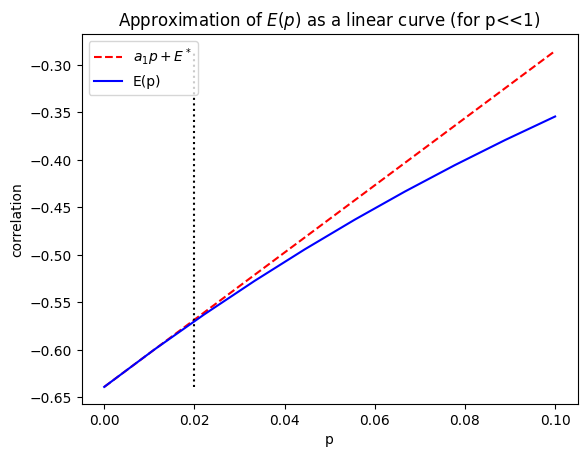

In [25]:
p_linear = 0.02 # point a partir du quel la courbe dérive
# on veut visuelement voir si nos point represente une droite
coeffs = np.polyfit(p_range[p_range<p_linear], correlation_p[p_range<p_linear], 1)
linear_eq = p_range*coeffs[0]+coeffs[1]

plt.figure()
plt.plot(p_range, linear_eq, color="red", label="$a_1p+ E^*$", linestyle='--')
plt.vlines(p_linear, np.min(correlation_p), max(max(correlation_p),linear_eq[-1]), color ='black', linestyle=':')
plt.plot(p_range, correlation_p, color="blue", label="E(p)")
plt.legend()
plt.title("Approximation of $E(p)$ as a linear curve (for p<<1)")
plt.xlabel("p")
plt.ylabel("correlation")
plt.show()

In [26]:
error_linear = np.mean(difference(linear_eq[p_range<p_linear], correlation_p[p_range<p_linear]))

print(f"Error of the approximation of a linear curve (for p<{p_linear}):", error_linear)

Error of the approximation of a linear curve (for p<0.02): 1.1102230246251565e-16


We can see that our system can be considered perturbative for small $p$.

Indeed, below $0.02$ our curve appears linear, but above this value the curve diverges.

The correlation is therefore **perturbative** for $p<0.02$ and $E(p)$ does indeed depend on $p$.

---

## Noise Scaling

We will need to **add noise** to our circuit without modifying $p$ in order to use our error correction method.

We know that a gate adds noise, so if we add $GG^\dagger = 1$, this adds noise to our system without even changing the result of the circuit.

This is what we do with the **Fold Circuit**: we add $GG^\dagger \dots GG^\dagger$ in front of the gates $G$ ($= R_X, R_Y, C_{NOT}$ in our case).

We choose the number of $GG^\dagger$ to place using the variable $scale$.


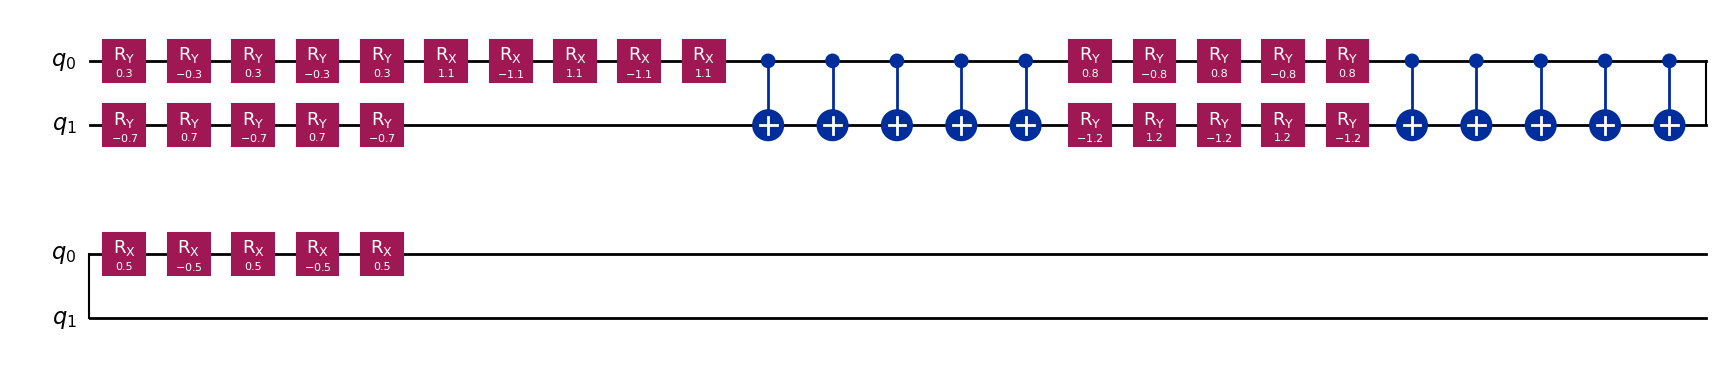

In [27]:
from qiskit.circuit import Gate

def fold_circuit(qc:QuantumCircuit, scale:int) -> QuantumCircuit:
  '''Construction du circuit plié
  Créer un nouveau QuantumCircuit
  Parcourir qc.data
  Pour chaque instruction :
  - si c’est une vraie porte → la plier
  - sinon → la copier telle quelle
  '''
  assert scale%2 == 1 # Scale need to be odd

  new_qc = QuantumCircuit(qc.num_qubits)
  k = (scale - 1)//2 # car scale = 2k+1

  for instruction in qc.data:
    instr = instruction.operation
    qargs = instruction.qubits
    cargs = instruction.clbits
    if isinstance(instr, Gate): # car cette methode ne s'applique qu'a des portes (unitaire par conception), pas au mesure..
      for _ in range(k):
        new_qc.append(instr, qargs) # G
        new_qc.append(instr.inverse(), qargs) # G†
      new_qc.append(instr, qargs) # G
    else:
      new_qc.append(instr, qargs, cargs)
  return new_qc

scale = 5
qc = initialize_circuit()
qc_folded = fold_circuit(qc, scale)

qc_folded.draw(output="mpl", style="iqp")

We must verify whether our folded circuit without noise gives us the same observable to be sure that the folding does not modify the result of the circuit.

$$\langle Z_0 Z_1\rangle_{folded} = \langle Z_0 Z_1\rangle_{original} \quad \text{without noise ?}$$

In [28]:
psi_folded = simulate(qc_folded, shots)

correlation_folded = compute_correlation(psi_folded)
print("correlation for folded circuit :", correlation_folded)
print(f"error : {difference(correlation, correlation_folded)}")

correlation for folded circuit : -0.6390459210354607
error : 1.1102230246251565e-16


The error is really small compared to 1 (of the order of $10^{-16}$) for $scale=5$, so we can consider that our folded circuit gives us the same state.

---

## Zero-Noise Extrapolation

We assume:
$$E(s) = E^* + a(sp) + b(sp)^2 + \dots$$
If $p$ is small, the quadratic term is negligible.

Therefore:
$$E(s) \approx E^* + asp$$
This is a straight line in $s$.

If we look at $s=0$:
$$E(0) = E^* = E_{ideal}$$

However, here we do not have access to $s=0$ because it is impossible to have $scale = 0$ for our folded circuit.

But since we have a straight line, we can extrapolate it and find:
$$E^* \approx \frac{3E_1-E_3}{2}$$

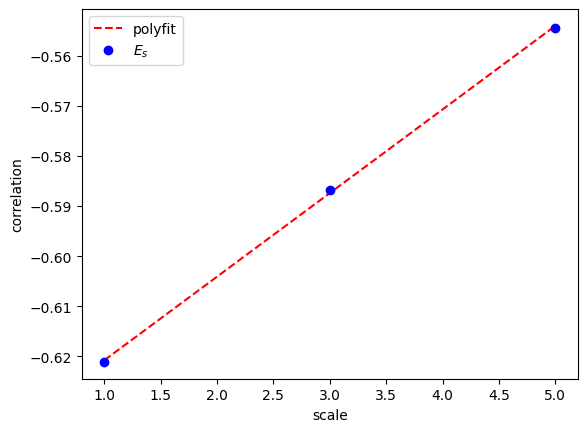

In [29]:
shots = 10000
p = 0.005 # on prend un p vraiment petit

qc = initialize_circuit()
E_ideal = ideal_correlation(qc, shots)

s_range = [1, 3, 5]

def zne(qc:QuantumCircuit, p:float, scales:list=[1, 3, 5], shots:int=10000) -> np.ndarray:
  correlation_s_list = []
  for s in scales :
    qc_folded_temp = fold_circuit(qc, s)
    rho = simulate_noise(qc_folded_temp, p, shots)
    correlation_s_list.append(compute_correlation_density_matrix(rho)) # calcul des E_s
  return np.array(correlation_s_list)

E_s = zne(qc, p, s_range, shots)

# on veut visuelement voir si nos point represente une droite
coeffs = np.polyfit(s_range, E_s, 1)
linear_eq = np.array(s_range)*coeffs[0]+coeffs[1]

plt.figure()
plt.plot(s_range, linear_eq, linestyle='--', color="red", label="polyfit")
plt.plot(s_range, E_s, 'o',color="blue", label="$E_s$")
plt.legend()
plt.xlabel("scale")
plt.ylabel("correlation")
plt.show()

Looking at the plot, we can clearly see a certain linearity.

### Richardson's first order

The extrapolated estimate of $E^*$:
$$E^* \approx \frac{3E_1-E_3}{2} = E^{(1)} = E_{ZNE}$$

The deviations from the ideal value:
$$\Delta E_s = E_s - E^*$$

If our regime is indeed linear:
$$E_s = E^* + asp$$

We should therefore have:
$$\Delta E_s = s \Delta E_1 \quad \implies \quad \frac{\Delta E_s}{\Delta E_1} = s $$

In [30]:
deltaE = E_s - E_ideal

for i in range(len(s_range)):
  print(f"deltaE_{i*2+1} / deltaE_1 = {(deltaE[i]/deltaE[0]).round(2)} for s = {s_range[i]}")

deltaE_1 / deltaE_1 = 1.0 for s = 1
deltaE_3 / deltaE_1 = 2.91 for s = 3
deltaE_5 / deltaE_1 = 4.71 for s = 5


For $\frac{\Delta E_s}{\Delta E_1}$, we find almost the expected values ($s$) with a small error ($\pm 0.1$) because $p$ is not infinitesimal (with $p=0.0001$ we are very close to 1, 3, and 5).

Therefore, our regime is almost perfectly linear, so we can make an extrapolated estimate of $E^*$.

In [31]:
print("E*_ideal :", E_ideal)
print("E_1      :", E_s[0])
print("Difference (without ZNE):", difference(E_s[0], E_ideal),"\n")

def E_extrap_1(E_s:np.ndarray) -> float:
  return (3 * E_s[0] - E_s[1])/2

E_ZNE =  E_extrap_1(E_s)

print("E*_ideal :", E_ideal)
print("E_ZNE    :", E_ZNE)
print("Difference (with ZNE):", difference(E_ZNE, E_ideal))

E*_ideal : -0.6390459210354608
E_1      : -0.6210880343644803
Difference (without ZNE): 0.017957886670980416 

E*_ideal : -0.6390459210354608
E_ZNE    : -0.638253999148277
Difference (with ZNE): 0.0007919218871837996


We find that extrapolating the curve with **Richardson** gives a value closer to the “ideal” value calculated without noise, unlike the first method without correction.

In [32]:
p_range = np.linspace(0, 0.05, 10)

E_ZNE_p, E_1_p = [], []
for p in p_range :
    E_s = zne(qc, p, s_range, shots)
    E_ZNE_p.append(E_extrap_1(E_s)) # calcul des E_ZNE(p)
    E_1_p.append(E_s[0])

p2 = np.array(p_range)**2 # calcul des p²
zne_error_p = difference(np.array(E_ZNE_p), E_ideal)
E1_error_p = difference(np.array(E_1_p), E_ideal)

We apply the method for several p values to see how our method behaves for different parameters.

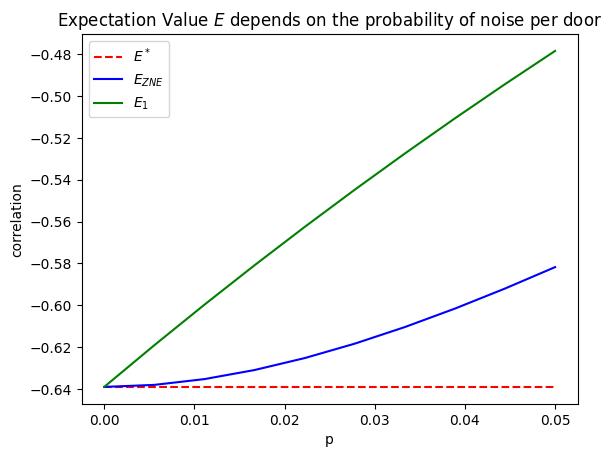

Average error for p < 0.05 without ZNE: 0.08333659516640413
Average error for p < 0.05 with    ZNE: 0.02175824956586514


In [33]:
plt.figure()
plt.hlines(E_ideal, min(p_range), max(p_range), color="red", linestyle="--", label="$E^*$")
plt.plot(p_range, E_ZNE_p, color="blue", label="$E_{ZNE}$")
plt.plot(p_range, E_1_p, color="green", label="$E_1$")
plt.xlabel("p")
plt.ylabel("correlation")
plt.title("Expectation Value $E$ depends on the probability of noise per door")
plt.legend()
plt.show()

print(f"Average error for p < {max(p_range)} without ZNE:", np.mean(E1_error_p))
print(f"Average error for p < {max(p_range)} with    ZNE:", np.mean(zne_error_p))

We can visually see that the ZNE method offers better results for the observable correlation for all $p$ compared to a classical measure.

Now let's look at the errors.

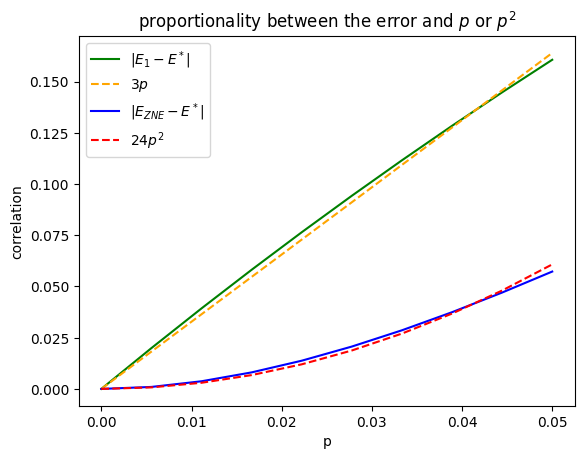

In [34]:
A = np.mean((E1_error_p[p_range>0] / p_range[p_range>0])[len(p_range)//2:]) # moyenne sur les p intermédiaires pour éviter le bruit numérique aux très petits p.
B = np.mean((zne_error_p[p2>0] / p2[p2>0])[len(p_range)//2:])

plt.figure()
# without ZNE
plt.plot(p_range, E1_error_p, color="green", label="$|E_{1}-E^*|$")
plt.plot(p_range, A * p_range, color="orange", linestyle="--", label=str(int(A))+"$ p$")
# with ZNE
plt.plot(p_range, zne_error_p, color="blue", label="$|E_{ZNE}-E^*|$")
plt.plot(p_range, B * p2, color="red", linestyle="--", label=str(int(B))+"$ p^2$")
plt.xlabel("p")
plt.ylabel("correlation")
plt.title("proportionality between the error and $p$ or $p^2$")
plt.legend()
plt.show()

It is clear that the error without the classic ZNE method is proportional to $p$, whereas with the ZNE method, the error is proportional to $p^2$.

---

## Conclusion

The numerical results confirm that **Zero-Noise Extrapolation** is based on a perturbative noise regime. When the noise parameter is sufficiently small (here $p$), the error on the observable admits an analytical Taylor series expansion. **Richardson extrapolation** cancels the linear term of this expansion, which transforms an error of order $O(p)$ into an error of order $O(p^2)$.

This improvement is clearly visible in our simulations, where **the extrapolated error** follows a **quadratic behavior in p**.

---

## References

- **Error Mitigation for Short-Depth Quantum Circuits**
Kristan Temme, Sergey Bravyi, and Jay M. Gambetta
*IBM T. J. Watson Research Center, Yorktown Heights, New York 10598, USA*
(Received 21 July 2017; published 3 November 2017)

- Yunos EL KADERI's course on **Quantum Computation and Error-Control Codes** (Master 2)

- [IBM Qiskit documentation](https://quantum.cloud.ibm.com/docs/en/guides)

- [Numpy documentation](https://numpy.org/doc/)

- [Matplotlib documentation](https://matplotlib.org/stable/index.html)